In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

# Discussion: Week 6


## Exercise: The Baseline RBC Model without Labor

The equilibrium conditions for the RBC model without labor are:

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right]\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = A_t K_t^{\alpha}\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to create a stochastic simulation of the RBC model. USe the following parameter values for the simulation:

| $$\rho$$ | $$\sigma$$ | $$\beta$$ | $$\alpha$$ | $$\delta $$ |
|----------|------------|-----------|------------|-------------|
| 0.75     | 0.006      | 0.99      | 0.35       |  0.025      |


### Model Preparation

Before proceding, let's recast the model in the form required for `linearsolve`. Write the model with all variables moved to the right-hand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = A_t K_t^{\alpha} - Y_t\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t - Y_t\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

Remember, capital and TFP are called *state variables* because their period $t+1$ values are determined by their period $t$ values. TFP is an *exogenous state variable* because it's $t+1$ value is subject to an exogenous shock $\epsilon_{t+1}$. Capital is an *endogenous state variable* because the $t+1$ value is completely determined in date $t$. Output, consumption, and investment are called a *costate* or *control* variables. Note that the model has 5 equations in 5 endogenous variables.

### Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series. CELL PROVIDED
parameters = pd.Series(dtype=float)
parameters['rho'] = .75
parameters['beta'] = 0.99
parameters['alpha'] = 0.35
parameters['delta'] = 0.025

# Create variable called `exo_states` that stores the names of each exogenous state variable.
exo_states = ['a']

# Create variable called `endo_states` that stores the names of each endogenous state variable.
endo_states = ['k']

# Create variable called `costates` that stores the names of the non-predetermined variables.
costates = ['y','c','i']

# Create a variable called 'sigma' that stores the value of sigma
sigma = 0.006

# Define a function that evaluates the equilibrium conditions of the model solved for zero. 
def equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # Euler equation
    euler_equation = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1)+1-p.delta)/fwd.c - 1/cur.c
    
    # Production function
    production_function = cur.a*cur.k**p.alpha - cur.y
    
    # Capital evolution
    capital_evolution = cur.i + (1 - p.delta)*cur.k - fwd.k
    
    # Market clearing
    market_clearing = cur.c+cur.i - cur.y
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_equation,
        production_function,
        capital_evolution,
        market_clearing,
        tfp_process
        ])

# Initialize the model into a variable named rbc_model`
rbc_model = ls.model(equations = equations,
                     exo_states=exo_states,
                     endo_states=endo_states,
                     costates=costates,
                     parameters=parameters)

# Compute the steady state numerically using .compute_ss() method of rbc_model
guess = [1,4,1,1,1]
rbc_model.compute_ss(guess)

# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of rbc_model
rbc_model.approximate_and_solve()

### Stochastic Simulation

Compute a 201 period stochastic simulation of the model. Set the seed for the simulation to 126. Since there is only one expgenous shock, the covariance matrix for the model shocks is:

\begin{align}
\text{Covariance matrix} & = \left[\sigma^2\right]
\end{align}

In [3]:
# Compute the stochastic simulation using the .stoch_sim() method of rbc_model
rbc_model.stoch_sim(T=201,seed=126,covariance_matrix = [sigma**2])

In [4]:
# Print the first 5 rows of rbc_model.simulated
print(rbc_model.simulated.head())

        e_a         a         k         y         c         i
0  0.005948  0.006464 -0.015455  0.001054 -0.008604  0.030140
1 -0.004694  0.000154 -0.014315 -0.004856 -0.008700  0.006719
2 -0.006422 -0.006306 -0.013789 -0.011132 -0.009189 -0.016984
3 -0.007073 -0.011803 -0.013869 -0.016657 -0.009927 -0.036925
4  0.007502 -0.001351 -0.014446 -0.006407 -0.008968  0.001308


In [5]:
# Print the first 5 rows of simulated output
print(rbc_model.simulated['y'].head())

0    0.001054
1   -0.004856
2   -0.011132
3   -0.016657
4   -0.006407
Name: y, dtype: float64


## Exercise: Analyze Simulation Results

On a single axis, plot the simulated values for output, consumption and investment.

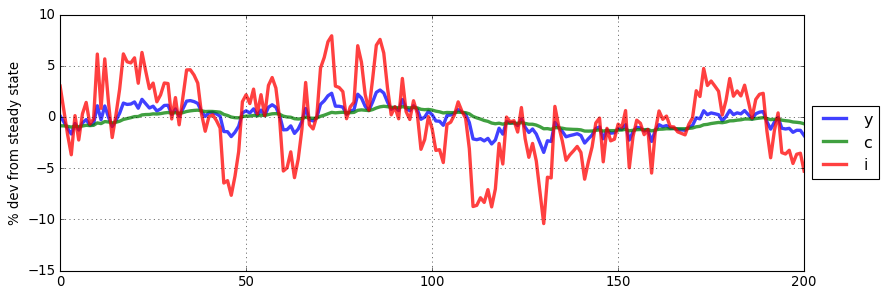

In [6]:
# Plot simulated results
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
(rbc_model.simulated[['y','c','i']]*100).plot(ax=ax,lw=3,grid=True,alpha=0.75)
ax.set_ylabel('% dev from steady state')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

**Questions**

1. What is the exogenous *cause* of the fluctuations in output, consumption and investment in your simulation?
2. Looking at the plot of your simulated data, which quantity — output, consumption or investment — has the smallest fluctuations from the steady state? What feature of the model leads to this?
3. Which quantity — output, consumption or investment — has the largest fluctuations from the steady state? What feature of the model leads to this?

**Answers**

1. Exogenous shocks to TFP. That is, exogenous shocks to the economy's production function.<!-- answer -->
2. Consumption. The household's Euler equation implies that the household wants to *smooth* consumption over time.<!-- answer -->
3. Investment. Again, the Euler equation. The household uses investment fluctuations to smooth consumption. When output is high, the household raises investment in order to accumulate capital and save some of the high production for later. Similarly, when output is low, the household reduces investment in order to deplete capital and therefore borrow against future output.<!-- answer -->